## 개요
- `EDA`를 진행할 때, 결측치가 있는 데이터를 시각화 하여 결측치 유무를 파악하였다. 
  + 참조: [EDA with Housing Price Prediction - Handling Missing Values](https://chloevan.github.io/kaggle/chapter_2_10_eda_with_missingvalues/)
- 이번 포스트에서는 결측치를 처리하는 코드를 작성할 것이다. 

## I. 구글 드라이브 연동
- 구글 코랩을 시작하면 언제든지 가장 먼저 해야 하는 것은 드라이브 연동이다.

In [1]:
from google.colab import drive # 패키지 불러오기 
from os.path import join  

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT, force_remount=True)           # 드라이브 기본 경로 Mount

MY_GOOGLE_DRIVE_PATH = 'My Drive/inflearn/chapter04' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/inflearn/chapter04


In [2]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/inflearn/chapter04


In [3]:
!ls

data


- 필자는 inflearn_kaggle 폴더안에 data, docs, source 등의 하위 폴더를 추가로 만들었다.
- 즉, data 안에 다운로드 받은 파일이 있을 것이다.

## II. 프로젝트 관련 패키지 불러오기
- 데이터 과학 관련 패키지들을 불러온다. 

In [4]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from IPython.core.display import display, HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- 시각화 진행 시, 일정한 `Template`을 작성한다. 

In [5]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

## III. 데이터 불러오기
- `train.csv`와 `test.csv` 데이터를 불러와서 확인해보는 소스코드를 작성한다. 

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("data import is done")

data import is done


- 실제로 데이터가 잘 불러와졌는지 다시한번 확인해본다. 

In [7]:
train.shape, test.shape

((1460, 81), (1459, 80))

- 이제 데이터 전처리를 위한 사적 작업이 모두 종료된 것이다. 

## IV. 결측치 처리방법 1 - "None" 또는 0으로 채우기
- 결측치 처리방법은 크게 2가지가 있다. 
  + 데이터 삭제 또는 데이터 채우기
- 데이터 삭제 진행하는 코드는 아래 튜토리얼을 확인한다. 
  + [Pandas Data Handling 1편](https://chloevan.github.io/python/python_edu/02_datatransformation/pandas_data_handling_1/)
- 본 포스트에서는 데이터를 채우는 방법에 대해 소개한다. 

### (1) 전체 데이터 결측치 확인
- 전체 데이터 결측치를 확인하는 방법은 아래와 같다. 

In [8]:
new_df = train.copy()

new_df_na = (new_df.isnull().sum() / len(new_df)) * 100
new_df_na.sort_values(ascending=False).reset_index(drop=True)
new_df_na = new_df_na.drop(new_df_na[new_df_na == 0].index).sort_values(ascending=False)[:30]
new_df_na

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

- 위 데이터를 가지고 시각화를 진행한다. 

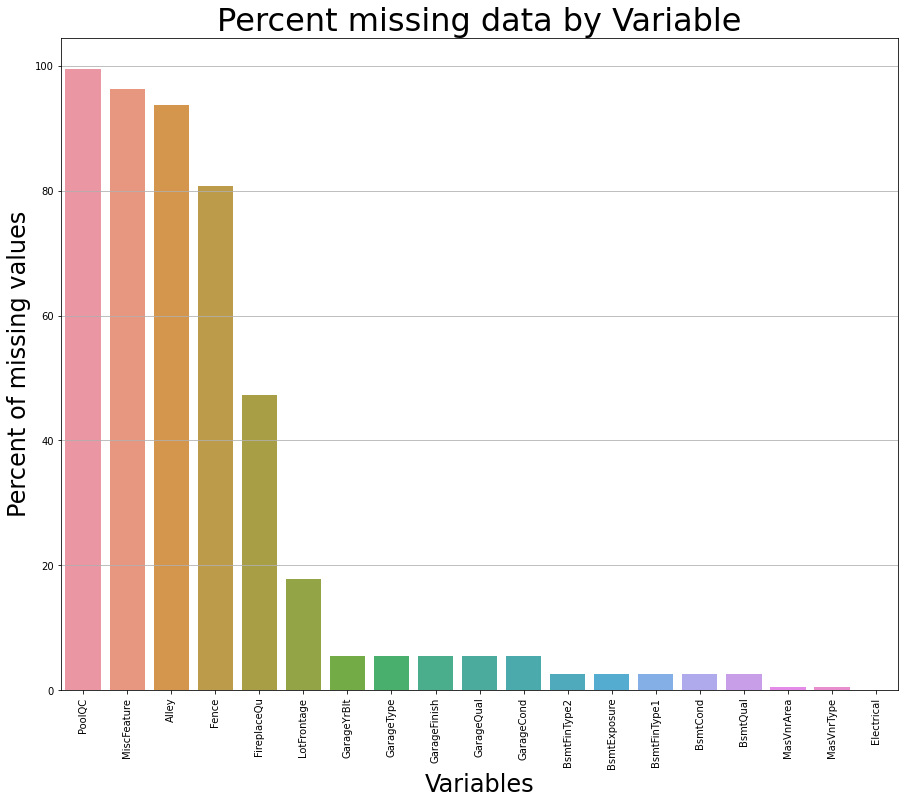

In [9]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=new_df_na.index, y=new_df_na)
plt.xlabel('Variables', fontsize=24)
plt.ylabel('Percent of missing values', fontsize=24)
plt.title('Percent missing data by Variable', fontsize=32)
plt.show()

- 위 그래프를 본 후 데이터를 채운다.
- 우선 각각의 데이터를 모두 "None" 또는 0으로 채운다. 
  + `Categorical Feature`는 `None`으로 채운다. 
  + `Numerical Feature`는 0으로 채운다. 

### (2) Categorical Feature 변수 다루기
- 이 때, 메서드는 fillna("None")을 사용한다. 

In [10]:
new_df["PoolQC"] = new_df["PoolQC"].fillna("None")
new_df["MiscFeature"] = new_df["MiscFeature"].fillna("None")

- 자주 반복되는 것 같을 것 같아서, `for-loop`로 데이터를 처리하도록 한다.
  + 우선, 전체 데이터에서 `categorical features`를 추출한다 `(List)`로 반환한다. 
  + for-loop로 작성 후, 위 소스코드를 적용한다. 

In [11]:
# Categorical List 추출
categorical_features = new_df.select_dtypes(exclude=[np.number])
print(categorical_features.columns)
print("The total number of categorical features are: ", len(categorical_features.columns))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
The total number of categorical features are:  43


In [12]:
for cat_fea in categorical_features:
  new_df[cat_fea] = new_df[cat_fea].fillna("None")

new_df_na = (new_df.isnull().sum() / len(new_df)) * 100
new_df_na.sort_values(ascending=False).reset_index(drop=True)
new_df_na = new_df_na.drop(new_df_na[new_df_na == 0].index).sort_values(ascending=False)[:30]
new_df_na

LotFrontage    17.739726
GarageYrBlt     5.547945
MasVnrArea      0.547945
dtype: float64

### (3) Numerical Feature 변수 처리
- 위 결과값으로 수치형 데이터는 3개의 데이터에서만 0으로 처리하면 되기 때문에, 강제적으로 `List` 변수를 만든 후 작업을 진행한다.

In [13]:
numerical_na_features = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for num_fea in numerical_na_features:
  new_df[num_fea] = new_df[num_fea].fillna(0)

new_df_na = (new_df.isnull().sum() / len(new_df)) * 100
new_df_na.sort_values(ascending=False).reset_index(drop=True)
new_df_na = new_df_na.drop(new_df_na[new_df_na == 0].index).sort_values(ascending=False)[:30]
new_df_na

Series([], dtype: float64)

- 실제 `new_df`에 `NA`가 있는지 확인한다. 

In [14]:
new_df.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

## V. What's Next
- 위 방법이 꼭 좋은 것은 아니다. 목적이 없기 때문이다. 
  + 그러나, 상대적으로 적은 결측치가 발생했을 경우에는 위와 같은 방법이 도움이 될 수도 있다. 
- 결측치를 채우는 다양한 방법이 있다. 
  + 참고: [Missing Data and Imputation](https://towardsdatascience.com/missing-data-and-imputation-89e9889268c8)